In [3]:
using FFTW, Plots, LinearAlgebra, SparseArrays, Printf, Plots, CSV, DataFrames
import Base: diff

# Trogdon Code
rnd = xx -> map(x -> round(x, digits = 5),xx)
mfftshift = x -> circshift(fftshift(x), isodd(length(x)) ? 1 : 0)
mfft = x -> fftshift(fft(fftshift(x),1)) # fft(x,1) is used so that
# when we operate on matrices below, the behavior is as desired.
mifft = x -> mfftshift(ifft(mfftshift(x),1))
mgrid = (n,L) -> -L .+ 2*L*(0:n-1)/n # array from -L to L leaving out L

# Setting things up
L = 200
q0 = x -> 2*exp.(-3x.^2)
m = 2^10 # larger L requires more grid points
X = mgrid(m,L)

if isodd(m)
    n = (1-length(X))./2 .+ (0:(length(X)-1))
else
    n = -1 .* length(X) ./ 2 .+ (0:(length(X)-1))
end
D = (pi/L) * Diagonal(1im.*n)
F = c -> -6 .* mfft(mifft(c) .* mifft(D*c))

#39 (generic function with 1 method)

## Reference solution

In [2]:
# Positive Exponential
# - change order of strang split
# - take out the time if statement
# - change position of ell

function rk4(a, t, dt) 
    f1 = exp(D.^3 * t) * F(exp(-D.^3 * t) * a)
    f2 = exp(D.^3 * (t+dt/2)) * F(exp(-D.^3 * (t+dt/2)) * (a+(dt/2)*f1))
    f3 = exp(D.^3 * (t+dt/2)) * F(exp(-D.^3 * (t+dt/2)) * (a+(dt/2)*f2))
    f4 = exp(D.^3 * (t+dt)) * F(exp(-D.^3 * (t+dt)) * (a+dt*f3))
    a = a + (dt/6)*(f1+2*f2+2*f3+f4)
    return a
end


# define general parameters
u = x -> 5*exp.(-x.^2) # initial condition
c = mfft(u(X))
dt = 0.0001
T = 4
t = 0.0
steps = convert(Int64,ceil(T/dt));

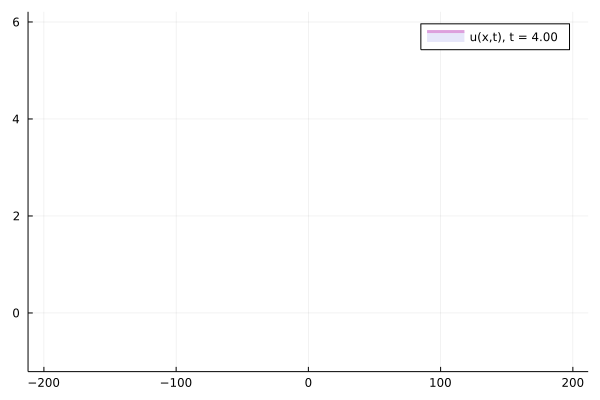

┌ Info: Saved animation to 
│   fn = C:\Users\annie\Dropbox\ArtificialBoundaryConditions\undamped_kdv.gif
└ @ Plots C:\Users\annie\.julia\packages\Plots\yfzIY\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\annie\\Dropbox\\ArtificialBoundaryConditions\\undamped_kdv.gif")
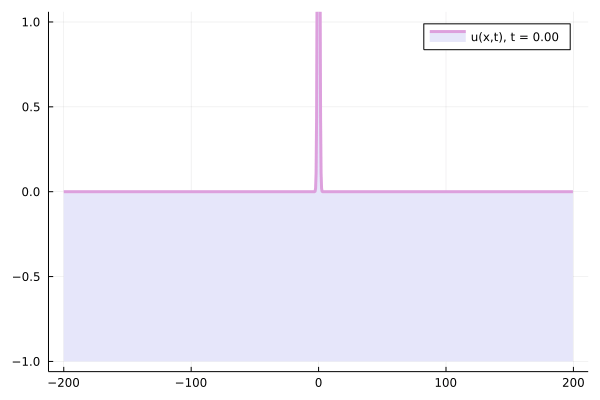

In [6]:
anim = Animation()
plot(X, mifft(c) |> real, fill = (-1,:lavender), line = :plum, linewidth = 3, yaxis = [-1,1], label = @sprintf("u(x,t), t = %1.2f",t)) |> IJulia.display
frame(anim)
t += dt
fr = 100 #frames/unit time
tb = convert(Int64,ceil(steps/(fr*T)))
a = c

for i = 2:steps+1
    a = rk4(c,dt,dt)
    c = exp(-D.^3*dt) * a
    t += dt
    if mod(i-1,tb) ≈ 0.0
        U = mifft(c)
        IJulia.clear_output(true)    
        plot(X, U |> real, fill = (-1,:lavender), line = :plum, linewidth = 3, yaxis = [-1,6], label = @sprintf("u(x,t), t = %1.2f",t)) |> IJulia.display
        frame(anim)
    end
end

gif(anim,"undamped_kdv.gif")

## Solving the KdV with Damping

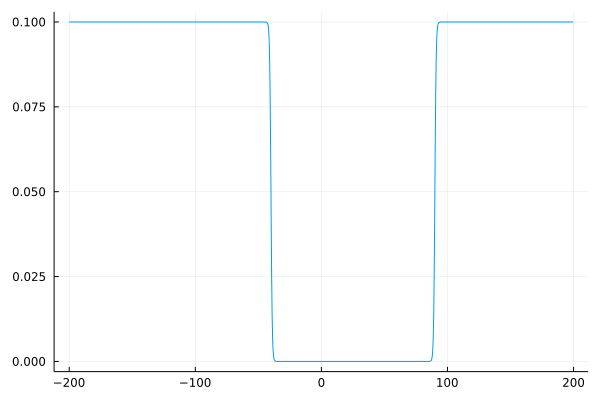

In [2]:
# Positive Exponential
# - change order of strang split
# - take out the time if statement
# - change position of ell

function CG(A,b,eps::Float64)
   x = 0.0*b; r = b; p = r; n = 0;
   while norm(r) > eps
        q = A(p)
        a = (r'*r)/(p'*q)
        x += a*p
        r_old = r
        r += - a*q
        b = (r'*r)/(r_old'*r_old)
        p = r + b*p 
        n += 1
    end
    x
end

# define general parameters
u = x -> 1.3*exp.(-x.^2) # initial condition
c = mfft(u(X))
dt = 0.0001
T = 4
t = 0.0
steps = convert(Int64,ceil(T/dt))

# set up for solving heat equation
ℓ1 = 90
ℓ2 = 40
γ = 1
σ = x ->  0.1*(0.5*(tanh.((x.-ℓ1)*γ) .+ 1) + 0.5*(tanh.((-x.-ℓ2)*γ) .+ 1))
D = (pi/L) * Diagonal(1im.*n)
Σ = Diagonal(σ(X))
A = x -> x + (dt/2)*D*mfft(Σ*mifft(D*x))
B = x -> x - (dt/2)*D*mfft(Σ*mifft(D*x))

plot(X,σ(X), legend = false)

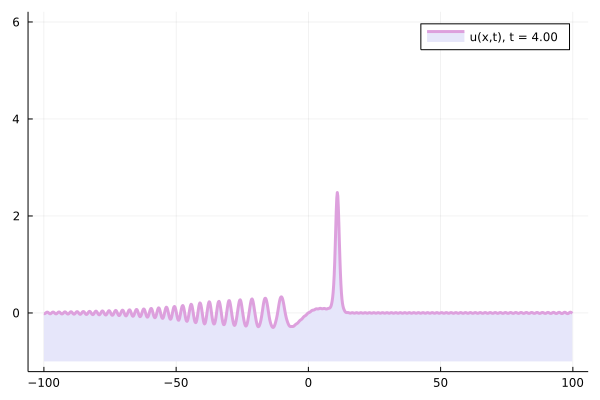

┌ Info: Saved animation to 
│   fn = C:\Users\annie\Dropbox\ArtificialBoundaryConditions\damped_kdv.gif
└ @ Plots C:\Users\annie\.julia\packages\Plots\yfzIY\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\annie\\Dropbox\\ArtificialBoundaryConditions\\damped_kdv.gif")
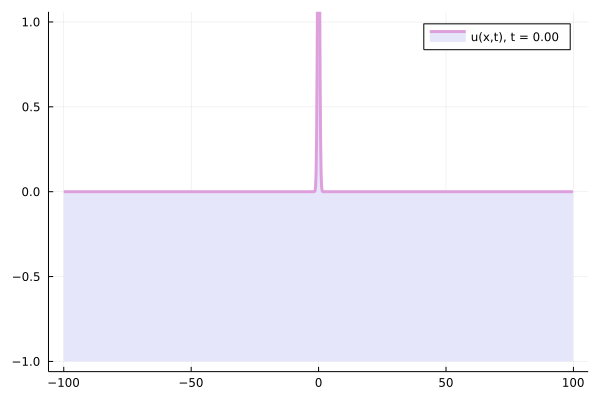

In [5]:
anim = Animation()
plot(X, mifft(c) |> real, fill = (-1,:lavender), line = :plum, linewidth = 3, yaxis = [-1,1], label = @sprintf("u(x,t), t = %1.2f",t)) |> IJulia.display
frame(anim)
t += dt
fr = 100 #frames/unit time
tb = convert(Int64,ceil(steps/(fr*T)))
a = c

for i = 2:steps+1
    if t < 0.5
        a = rk4(c,dt,dt)
        c = exp(-D.^3*dt) * a
        # c = RK4(c,t,dt) # this doesn't appear to be working?
    else
        a = rk4(c,dt/2,dt/2)
        c_til = exp(-D.^3*dt/2) * a
        c_bar = CG(B, A(c_til), 1e-10)
        a = rk4(c_bar,dt/2,dt/2)
        c = exp(-D.^3*dt/2) * a 
    end
    t += dt
    
    if mod(i-1,tb) ≈ 0.0
        U = mifft(c)
        IJulia.clear_output(true)    
        plot(X, U |> real, fill = (-1,:lavender), line = :plum, linewidth = 3, yaxis = [-1,6], label = @sprintf("u(x,t), t = %1.2f",t)) |> IJulia.display
        frame(anim)
    end
end

gif(anim,"damped_kdv.gif")

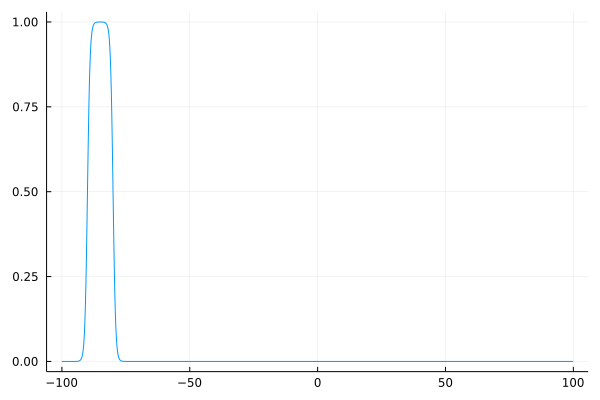

In [6]:
# define general parameters
u = x -> 1.3*exp.(-x.^2) # initial condition
c = mfft(u(X))
dt = 0.0001
T = 4
t = 0.0
steps = convert(Int64,ceil(T/dt))

# set up for solving heat equation
ℓ1 = -80
ℓ2 = 90
γ = 1
σ = x ->  (1 .- (0.5*(tanh.((x.-ℓ1)*γ) .+ 1) + 0.5*(tanh.((-x.-ℓ2)*γ) .+ 1)))
D = (pi/L) * Diagonal(1im.*n)
Σ = Diagonal(σ(X))
A = x -> x + (dt/2)*D*mfft(Σ*mifft(D*x))
B = x -> x - (dt/2)*D*mfft(Σ*mifft(D*x))

plot(X,σ(X), legend = false)

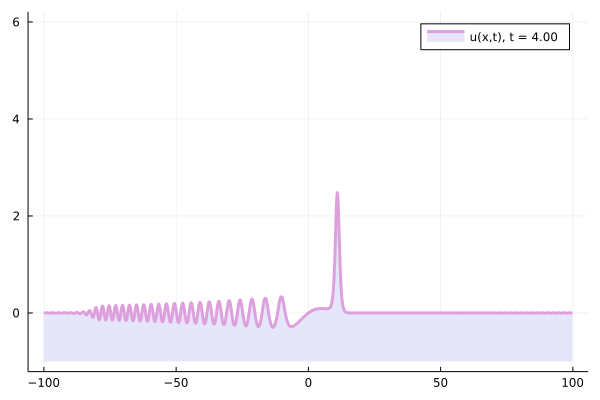

┌ Info: Saved animation to 
│   fn = C:\Users\annie\Dropbox\ArtificialBoundaryConditions\bumb_damped_kdv.gif
└ @ Plots C:\Users\annie\.julia\packages\Plots\yfzIY\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\annie\\Dropbox\\ArtificialBoundaryConditions\\bumb_damped_kdv.gif")
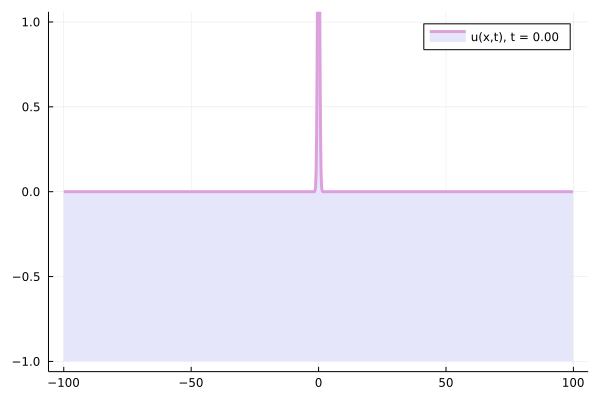

In [7]:
anim = Animation()
plot(X, mifft(c) |> real, fill = (-1,:lavender), line = :plum, linewidth = 3, yaxis = [-1,1], label = @sprintf("u(x,t), t = %1.2f",t)) |> IJulia.display
frame(anim)
t += dt
fr = 100 #frames/unit time
tb = convert(Int64,ceil(steps/(fr*T)))
a = c

for i = 2:steps+1
    if t < 0.5
        a = rk4(c,dt,dt)
        c = exp(-D.^3*dt) * a
    else
        a = rk4(c,dt/2,dt/2)
        c_til = exp(-D.^3*dt/2) * a
        c_bar = CG(B, A(c_til), 1e-10)
        a = rk4(c_bar,dt/2,dt/2)
        c = exp(-D.^3*dt/2) * a 
    end
    t += dt
    
    if mod(i-1,tb) ≈ 0.0
        U = mifft(c)
        IJulia.clear_output(true)    
        plot(X, U |> real, fill = (-1,:lavender), line = :plum, linewidth = 3, yaxis = [-1,6], label = @sprintf("u(x,t), t = %1.2f",t)) |> IJulia.display
        frame(anim)
    end
end

gif(anim,"bumb_damped_kdv.gif")

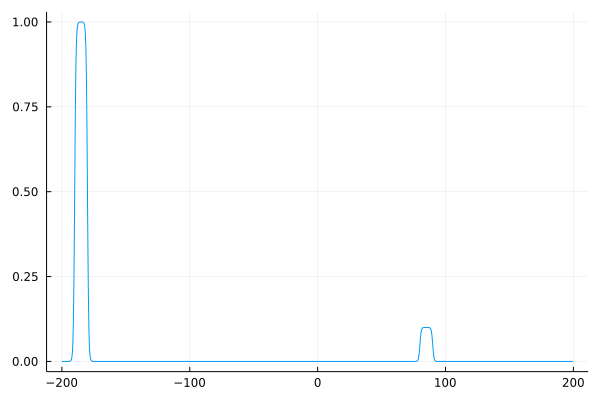

In [19]:
# define general parameters
u = x -> 1.3*exp.(-x.^2) # initial condition
c = mfft(u(X))
dt = 0.0001
T = 4
t = 0.0
steps = convert(Int64,ceil(T/dt))

# set up for solving heat equation
ℓ1 = -180
ℓ2 = 190
γ = 1
σ1 = x ->  (1 .- (0.5*(tanh.((x.-ℓ1)*γ) .+ 1) + 0.5*(tanh.((-x.-ℓ2)*γ) .+ 1)))
shift = 270
σ = x ->  σ1(x) + 0.1*σ1(x.-shift)
D = (pi/L) * Diagonal(1im.*n)
Σ = Diagonal(σ(X))
A = x -> x + (dt/2)*D*mfft(Σ*mifft(D*x))
B = x -> x - (dt/2)*D*mfft(Σ*mifft(D*x))

plot(X,σ(X), legend = false)

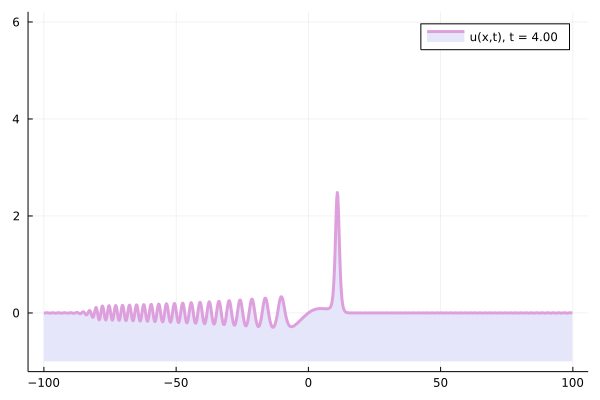

┌ Info: Saved animation to 
│   fn = C:\Users\annie\Dropbox\ArtificialBoundaryConditions\doublebumb_damped_kdv.gif
└ @ Plots C:\Users\annie\.julia\packages\Plots\yfzIY\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\annie\\Dropbox\\ArtificialBoundaryConditions\\doublebumb_damped_kdv.gif")
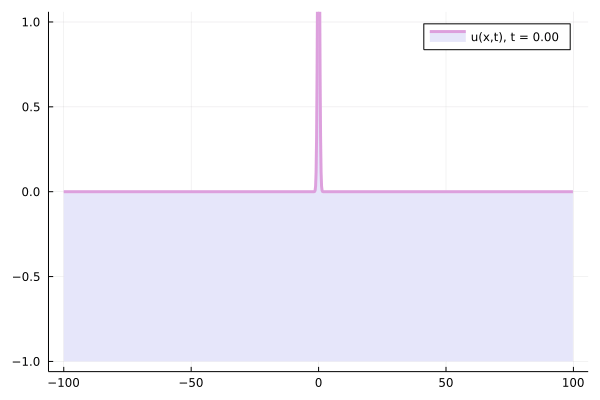

In [9]:
anim = Animation()
plot(X, mifft(c) |> real, fill = (-1,:lavender), line = :plum, linewidth = 3, yaxis = [-1,1], label = @sprintf("u(x,t), t = %1.2f",t)) |> IJulia.display
frame(anim)
t += dt
fr = 100 #frames/unit time
tb = convert(Int64,ceil(steps/(fr*T)))
a = c

for i = 2:steps+1
    if t < 0.5
        a = rk4(c,dt,dt)
        c = exp(-D.^3*dt) * a
    else
        a = rk4(c,dt/2,dt/2)
        c_til = exp(-D.^3*dt/2) * a
        c_bar = CG(B, A(c_til), 1e-10)
        a = rk4(c_bar,dt/2,dt/2)
        c = exp(-D.^3*dt/2) * a 
    end
    t += dt
    
    if mod(i-1,tb) ≈ 0.0
        U = mifft(c)
        IJulia.clear_output(true)    
        plot(X, U |> real, fill = (-1,:lavender), line = :plum, linewidth = 3, yaxis = [-1,6], label = @sprintf("u(x,t), t = %1.2f",t)) |> IJulia.display
        frame(anim)
    end
end

gif(anim,"doublebumb_damped_kdv.gif")

## Comparing to True Solution

In [20]:
# 1. download csv file and turn into array
#         - column 1: x values
#         - column 2: f(x) values
# 2. run my code up with new initial condition to get to T = 5
# 3. use trig interp to evaluate my solution at same gridpoints as true solution
# 4. calculate max difference between elements of both vectors

struct trig_interp
    L::Float64
    c::Vector{Complex{Float64}}
end

function (tr::trig_interp)(x) # just sums the Fourier series!
    m = length(tr.c)
    mm = convert(Int64,floor( m/2 ))
    σ = isodd(m) ? 1im*pi/m : 0. # if n is odd we need to rotate coefs
    ex = exp.(-1im*pi*mm*x/tr.L + mm*σ)
    ex1 = exp.(1im*pi*x/tr.L-σ)
    sum = tr.c[1]*ex
    for i = 2:length(tr.c)
        ex  =  ex.*ex1
        sum += tr.c[i]*ex
    end
    return sum/m
end    


# true solution
data = Array(CSV.read("out.csv", DataFrame))

# my solution
u = x -> 1.3*exp.(-x.^2) # new initial condtion
c = mfft(u(X))
dt = 0.0001
T = 5
t = 0.0
steps = convert(Int64,ceil(T/dt))
fr = 100 #frames/unit time
tb = convert(Int64,ceil(steps/(fr*T)))
a = c

for i = 2:steps+1 # using double bump sigma
    if t < 0.5
        a = rk4(c,dt,dt)
        c = exp(-D.^3*dt) * a
    else
        a = rk4(c,dt/2,dt/2)
        c_til = exp(-D.^3*dt/2) * a
        c_bar = CG(B, A(c_til), 1e-10)
        a = rk4(c_bar,dt/2,dt/2)
        c = exp(-D.^3*dt/2) * a 
    end
    t += dt
end

fm = trig_interp(L,c)

# error
x_vals = data[:,1]
true_sol = data[:,2]
my_sol = map(fm,x_vals) |> real
error = abs(maximum(true_sol .- my_sol)) |> rnd

7.0e-5

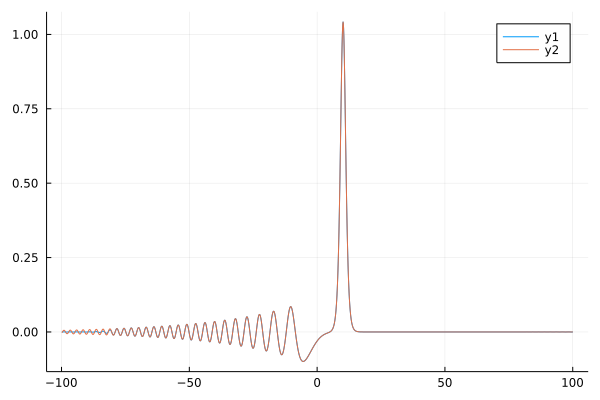

In [15]:
plot(x_vals,my_sol)
plot!(x_vals,true_sol)